## IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
# Loading train and test data and analyzing its first 5 columns
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.head()

,TID,Date,Property Type,OldvNew,Duration,AddressLine1,AddressLine2,Street,Locality,Town,Taluka,District,Postcode,Price,Price Category
0,909733,26-11-2018,T,N,F,57,NaN,BENSKYVM XMKBBM,NaN,EYLFYL,OUSGLBQ,JKBUMBK EYLFYL,B4 7XD,845.0,A
1,827610,26-10-2018,T,N,L,4,NaN,EYLJ NBUFYZ,NaN,HKRXMYE,SRMQ YV HKRXMYE,SRMQ YV HKRXMYE,HX03 0FQ,225.0,A
2,680513,07-09-2018,D,Y,F,5,NaN,BPBKXEBQ JUKFBLX,GRLJX ZYKMOQ,ZRLSOBXMBK,ZRLSOBXMBK,OUNCXORKB,XY56 9JD,872.5,A
3,798754,19-10-2018,S,N,F,55,NaN,SYKYLUMRYL SEYXB,OUCCRXHWKJO,LYKZRSO,LYKMO LYKVYEG,LYKVYEG,LK05 7KE,130.1,A
4,612097,17-08-2018,S,N,F,20,NaN,MOB SUWXBZUQ,NaN,XYWMOCYKM,XBVMYL,NBKXBQXRFB,CK8 2TU,160.0,A


## Pre-processing

In [3]:
df_train.isnull().sum() # cecking for null values in the data

TID                    0
Date                   0
Property Type          0
OldvNew                0
Duration               0
AddressLine1           0
AddressLine2      123627
Street              2661
Locality           88872
Town                   0
Taluka                 0
District               0
Postcode             653
Price                  0
Price Category         0
dtype: int64

In [4]:
# Preparing training data
X_train = df_train.drop(columns = ['TID', 'AddressLine2', 'Locality', 'Price']) # dropped the 2 columns with many missng columns.
y = df_train['Price'] # Label to be predicted

In [5]:
# FIlling the NaN(missing) values in the 2 other columns with more than 50% data with their mode values, as they are categorical. 
X_train['Street'].fillna(X_train['Street'].mode()[0], inplace = True)
X_train['Postcode'].fillna(X_train['Postcode'].mode()[0], inplace = True)

In [6]:
X_train.isnull().sum() # final check for null values

Date              0
Property Type     0
OldvNew           0
Duration          0
AddressLine1      0
Street            0
Town              0
Taluka            0
District          0
Postcode          0
Price Category    0
dtype: int64

## Feature Engineering

In [7]:
# function for feature processing,i.e., to make the data clean and feadable.
def Feature_processing(X):
  freq_col = ['AddressLine1', 'Taluka', 'Town', 'District', 'Street', 'Postcode'] # vague columns chosen to be encoded by their frequency of occurence
  for i in freq_col:
    freq_en = X.groupby(i).size() # grouping the data of each column by their frequency(i.e: size of each type in the particular  column)
    freq_en = freq_en/len(X) # lowering the range of values between 0 to 1, so that training can be done efficiently
    X[i] = X[i].map(freq_en) # mapping the particular type in each column with its encoded version
  # splitting the date column into day, month and year and dropping the parent column
  X['day'] = X['Date'].str.split('-', 2, expand = True)[0].astype('int64')
  X['month'] = X['Date'].str.split('-', 2, expand = True)[1].astype('int64')
  X['year'] = X['Date'].str.split('-', 2, expand = True)[2].astype('int64')
  X = X.drop(columns = ['Date'])
  X = pd.get_dummies(X) # one hot encoding of the left out columns
  return X

In [8]:
X_train = Feature_processing(X_train) # calling the function to be executed on X_train

In [9]:
X_train.head()

,AddressLine1,Street,Town,Taluka,District,Postcode,day,month,year,Property Type_D,Property Type_F,Property Type_O,Property Type_S,Property Type_T,OldvNew_N,OldvNew_Y,Duration_F,Duration_L,Price Category_A,Price Category_B
0,0.013589,0.000014,0.056077,0.002385,0.098845,0.000014,26,11,2018,0,0,0,0,1,1,0,1,0,1,0
1,0.039893,0.000042,0.015443,0.007812,0.007812,0.000007,26,10,2018,0,0,0,0,1,1,0,0,1,1,0
2,0.044663,0.000007,0.000944,0.001721,0.024619,0.000007,7,9,2018,1,0,0,0,0,0,1,1,0,1,0
3,0.012911,0.000014,0.007931,0.002616,0.018275,0.000014,19,10,2018,0,0,0,1,0,1,0,1,0,1,0
4,0.002035,0.000147,0.001972,0.004721,0.024248,0.000007,17,8,2018,0,0,0,1,0,1,0,1,0,1,0


In [10]:
# Same steps are followed with the test data
X_test = df_test.drop(columns = ['TID', 'AddressLine2', 'Locality']) 

In [11]:
X_test['Street'].fillna(X_test['Street'].mode()[0], inplace = True)
X_test['Postcode'].fillna(X_test['Postcode'].mode()[0], inplace = True)

In [12]:
X_test = Feature_processing(X_test)

In [13]:
X_test.head()

,AddressLine1,Street,Town,Taluka,District,Postcode,day,month,year,Property Type_D,Property Type_F,Property Type_O,Property Type_S,Property Type_T,OldvNew_N,OldvNew_Y,Duration_F,Duration_L,Price Category_A,Price Category_B
0,0.000016,0.000326,0.002040,0.001844,0.001844,0.000016,15,2,2018,0,1,0,0,0,1,0,0,1,1,0
1,0.004977,0.000196,0.002823,0.002203,0.015944,0.000016,13,8,2018,0,0,0,1,0,1,0,1,0,1,0
2,0.042838,0.000049,0.001159,0.001811,0.010934,0.000016,25,6,2018,0,0,0,0,1,1,0,0,1,1,0
3,0.004210,0.000033,0.015503,0.008143,0.008143,0.000016,3,5,2018,0,0,0,0,1,1,0,1,0,1,0
4,0.042838,0.000016,0.000375,0.002154,0.017217,0.000016,5,1,2018,0,1,0,0,0,1,0,0,1,1,0


## Simple Visualization

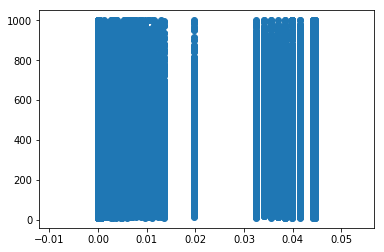

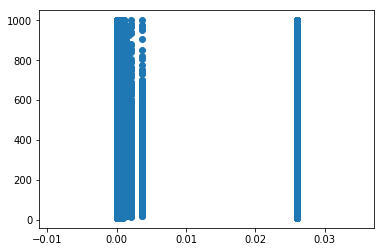

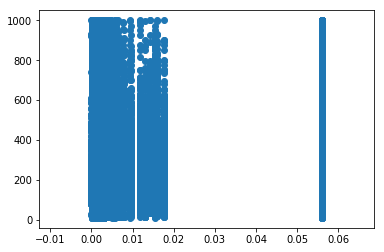

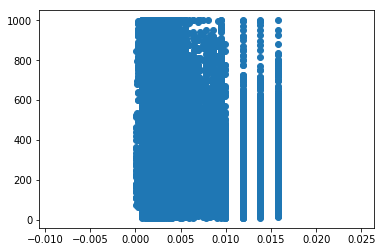

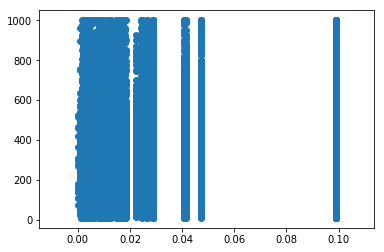

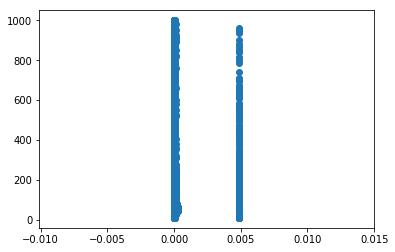

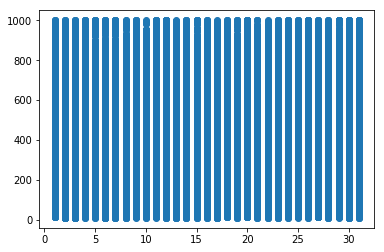

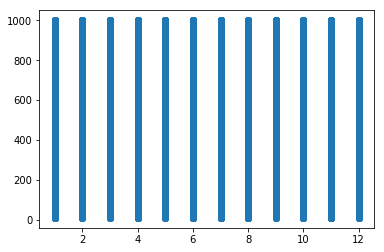

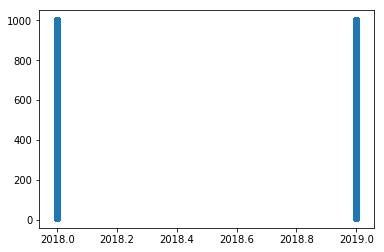

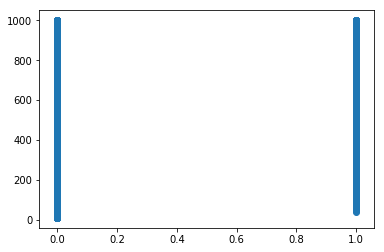

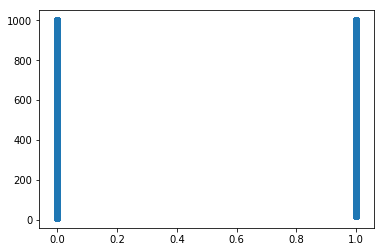

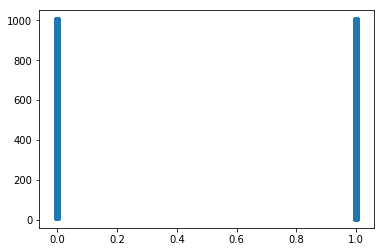

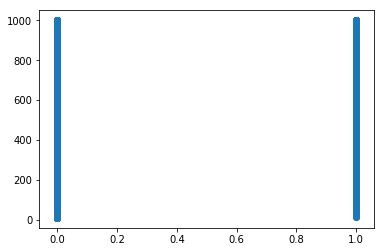

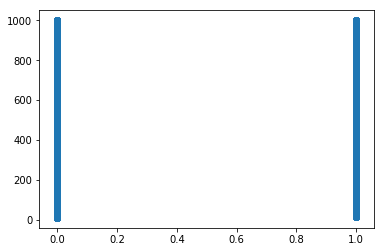

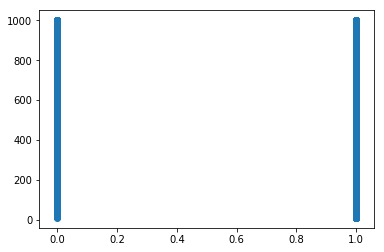

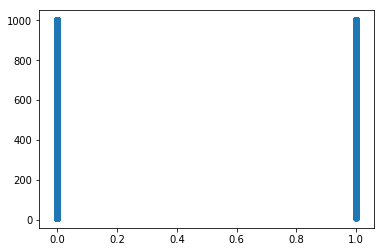

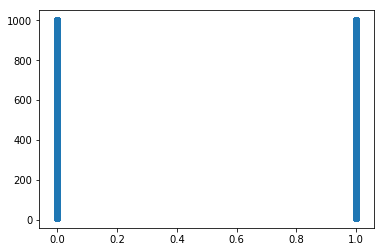

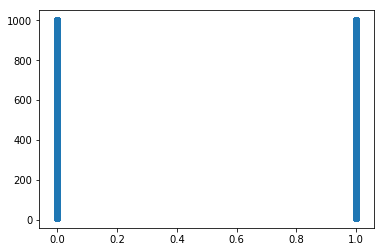

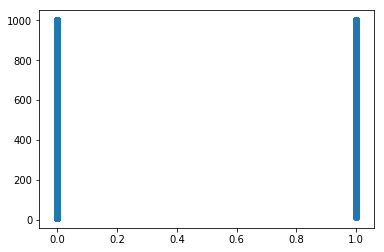

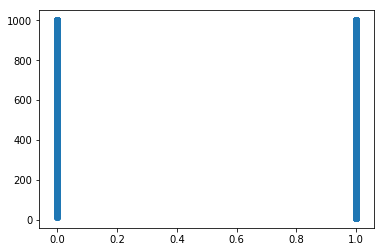

In [15]:
for i in X_train:
    plt.scatter(X_train[i], y)
    plt.show()

In [16]:
# Looking at the above data, though linear models like Linear Regression and SVM can do good, they would be slow in training this amount of data. Tree based models will fit them efficiently train irrespective of their behaviour and also save a lot of time in training the data 

In [17]:
# from sklearn.model_selection import train_test_split
# X1, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.33, random_state=42)

## Model Selection and ensembling

In [18]:
xgb = XGBRegressor(n_estimators = 150) # xgboost regressor
lgbm = LGBMRegressor(n_estimators = 150) # light gbm regressor
# use the 2 models to fit the training data
xgb.fit(X_train, y)
lgbm.fit(X_train, y)
y_pred = 0.5*xgb.predict(X_test) + 0.5*lgbm.predict(X_test) # Ensemble model with equal weights on the 2

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[14:44:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [19]:
# from sklearn.metrics import mean_squared_error
# np.sqrt(mean_squared_error(y_pred, y_test))

## Submission in the right format

In [20]:
sub = pd.DataFrame({'TID': df_test['TID'], 'Price': y_pred}) # preparing a submission dataframe with required columns
sub.head()

,TID,Price
0,102779,180.268090
1,598463,174.172997
2,443492,170.725067
3,305046,276.247750
4,6198,246.795483


In [21]:
sub1 = sub.sort_values(by = 'TID', ascending = 1) # arranging the data in ascending order by TID columns

In [23]:
sub1.to_csv('submis.csv', index = False) # converting the above dataframe into a .csv file